<a href="https://colab.research.google.com/github/maliozdemir1/dsa210-project-impact-of-climate-on-gastronomic-diversity/blob/main/MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import re

FOODS_PATH = "manual_clean_en.csv"
CLIM_PATH  = "iklim_mgm_1991_2020.csv"

def normalize_province(s):
    if pd.isna(s): return np.nan
    s = str(s).strip().upper()
    tr_map = str.maketrans({"İ":"I","ı":"I","Ş":"S","Ğ":"G","Ü":"U","Ö":"O","Ç":"C","Â":"A","Ê":"E","Û":"U"})
    s = s.translate(tr_map)
    s = re.sub(r"[^A-Z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s.replace(" ", "")

foods = pd.read_csv(FOODS_PATH, encoding="utf-8-sig")
clim  = pd.read_csv(CLIM_PATH,  encoding="utf-8-sig")

foods["kcal_100g"] = pd.to_numeric(foods["kcal_100g"], errors="coerce")
clim["temp_annual_mean"] = pd.to_numeric(clim["temp_annual_mean"], errors="coerce")
clim["prec_annual_total"] = pd.to_numeric(clim["prec_annual_total"], errors="coerce")

foods["prov_key"] = foods["province"].apply(normalize_province)
clim["prov_key"]  = clim["province"].apply(normalize_province)

foods_prov = (foods.groupby(["prov_key","province"], dropna=False)
              .agg(n_foods=("food_name","size"),
                   mean_kcal=("kcal_100g","mean"),
                   median_kcal=("kcal_100g","median"),
                   std_kcal=("kcal_100g","std"))
              .reset_index())

merged = foods_prov.merge(
    clim[["prov_key","temp_annual_mean","prec_annual_total"]],
    on="prov_key", how="inner"
)

print("Merged provinces:", merged.shape[0])
display(merged.head())


Merged provinces: 79


,prov_key,province,n_foods,mean_kcal,median_kcal,std_kcal,temp_annual_mean,prec_annual_total
0,ADANA,Adana,20,224.400000,227.5,212.563402,19.458333,680.8
1,ADIYAMAN,Adıyaman,7,216.857143,171.0,207.880117,17.683333,729.5
2,AFYONKARAHISAR,Afyonkarahisar,47,239.808511,241.0,122.455429,11.691667,451.4
3,AGRI,Ağrı,6,283.500000,276.5,61.282134,6.691667,512.9
4,AKSARAY,Aksaray,11,308.000000,277.0,139.529208,12.775000,349.4


Initially we need to merge the data to use all the values of climate such as temperature, precipitation and calories.

In [2]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Features + target
X = merged[["temp_annual_mean","prec_annual_total","n_foods"]].copy()
y = merged["mean_kcal"].copy()

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# --- Ridge Regression pipeline ---
ridge_model = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=1.0, random_state=42))
])

# scores (negative MSE, R2)
ridge_rmse = np.sqrt(-cross_val_score(ridge_model, X, y, cv=cv, scoring="neg_mean_squared_error"))
ridge_r2   = cross_val_score(ridge_model, X, y, cv=cv, scoring="r2")

print("RIDGE (5-fold)")
print("RMSE:", ridge_rmse.mean().round(2), "±", ridge_rmse.std().round(2))
print("R2  :", ridge_r2.mean().round(3),  "±", ridge_r2.std().round(3))

# --- Random Forest Regressor ---
rf_model = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestRegressor(
        n_estimators=500,
        random_state=42,
        min_samples_leaf=2
    ))
])

rf_rmse = np.sqrt(-cross_val_score(rf_model, X, y, cv=cv, scoring="neg_mean_squared_error"))
rf_r2   = cross_val_score(rf_model, X, y, cv=cv, scoring="r2")

print("\nRANDOM FOREST (5-fold)")
print("RMSE:", rf_rmse.mean().round(2), "±", rf_rmse.std().round(2))
print("R2  :", rf_r2.mean().round(3),  "±", rf_r2.std().round(3))


RIDGE (5-fold)
RMSE: 45.16 ± 7.21
R2  : -0.173 ± 0.138

RANDOM FOREST (5-fold)
RMSE: 47.98 ± 6.06
R2  : -0.378 ± 0.389


In [3]:
from sklearn.inspection import permutation_importance

X = merged[["temp_annual_mean","prec_annual_total","n_foods"]].copy()
y = merged["mean_kcal"].copy()

# Fit Ridge
ridge_model.fit(X, y)
coef = ridge_model.named_steps["ridge"].coef_
features = list(X.columns)

print("Ridge coefficients:")
for f, c in sorted(zip(features, coef), key=lambda t: abs(t[1]), reverse=True):
    print(f"  {f:20s} {c:+.4f}")

# Fit RF
rf_model.fit(X, y)

# Permutation importance (model-agnostic)
imp = permutation_importance(rf_model, X, y, n_repeats=30, random_state=42)
imp_df = pd.DataFrame({"feature": features, "importance_mean": imp.importances_mean, "importance_std": imp.importances_std})
imp_df = imp_df.sort_values("importance_mean", ascending=False)

print("\nRandom Forest permutation importance:")
display(imp_df)


Ridge coefficients:
  n_foods              +3.3665
  temp_annual_mean     -2.4376
  prec_annual_total    +0.3882

Random Forest permutation importance:


,feature,importance_mean,importance_std
2,n_foods,0.691138,0.105612
1,prec_annual_total,0.243725,0.034706
0,temp_annual_mean,0.225474,0.027963


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# binary target: high kcal if >= median
y_bin = (merged["mean_kcal"] >= merged["mean_kcal"].median()).astype(int)

X = merged[["temp_annual_mean","prec_annual_total","n_foods"]].copy()

cv = KFold(n_splits=5, shuffle=True, random_state=42)

log_model = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=2000, random_state=42))
])

rf_clf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(
        n_estimators=500,
        random_state=42,
        min_samples_leaf=2
    ))
])

log_acc = cross_val_score(log_model, X, y_bin, cv=cv, scoring="accuracy")
rf_acc  = cross_val_score(rf_clf,   X, y_bin, cv=cv, scoring="accuracy")

print("LOGISTIC (5-fold) accuracy:", log_acc.mean().round(3), "±", log_acc.std().round(3))
print("RF CLASSIFIER (5-fold) accuracy:", rf_acc.mean().round(3), "±", rf_acc.std().round(3))


LOGISTIC (5-fold) accuracy: 0.531 ± 0.04
RF CLASSIFIER (5-fold) accuracy: 0.492 ± 0.065


Cluster sizes:


,count
cluster,
0,39
1,10
2,30



Mean kcal by cluster:


,cluster,count,mean,median,std
0,0,39,239.964867,237.909091,34.719065
1,1,10,217.517671,211.195804,53.280828
2,2,30,240.492733,235.304348,52.012247


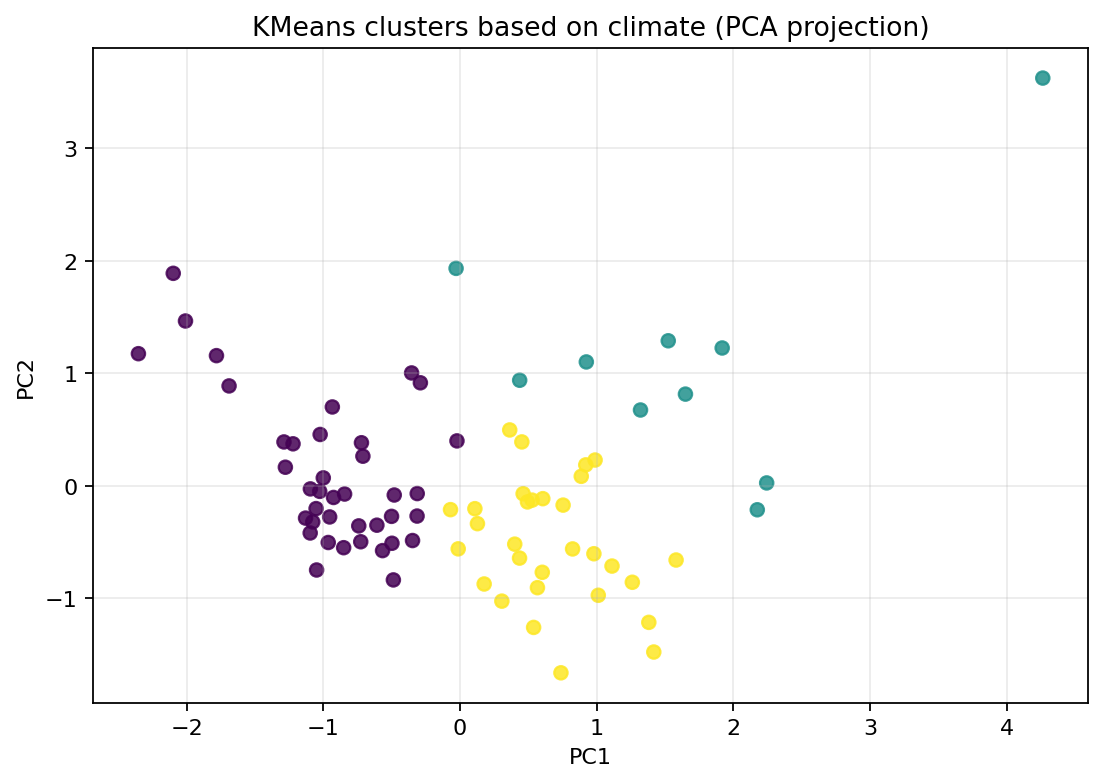

In [5]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

Xc = merged[["temp_annual_mean","prec_annual_total"]].copy()

kmeans_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("kmeans", KMeans(n_clusters=3, random_state=42, n_init=20))
])

clusters = kmeans_pipe.fit_predict(Xc)
merged["cluster"] = clusters

print("Cluster sizes:")
display(merged["cluster"].value_counts().sort_index())

print("\nMean kcal by cluster:")
display(merged.groupby("cluster")["mean_kcal"].agg(["count","mean","median","std"]).reset_index())

# 2D visualization via PCA
X_scaled = StandardScaler().fit_transform(SimpleImputer(strategy="median").fit_transform(Xc))
pca = PCA(n_components=2, random_state=42)
XY = pca.fit_transform(X_scaled)

import matplotlib.pyplot as plt
plt.figure(figsize=(7,5), dpi=160)
plt.scatter(XY[:,0], XY[:,1], c=clusters, alpha=0.85)
plt.title("KMeans clusters based on climate (PCA projection)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()


In [6]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

FOODS_PATH = "manual_clean_en.csv"
CLIM_PATH  = "iklim_mgm_1991_2020.csv"

def normalize_province(s):
    if pd.isna(s): return np.nan
    s = str(s).strip().upper()
    tr_map = str.maketrans({"İ":"I","ı":"I","Ş":"S","Ğ":"G","Ü":"U","Ö":"O","Ç":"C","Â":"A","Ê":"E","Û":"U"})
    s = s.translate(tr_map)
    s = re.sub(r"[^A-Z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s.replace(" ", "")

# 1) Load
foods = pd.read_csv(FOODS_PATH, encoding="utf-8-sig")
clim  = pd.read_csv(CLIM_PATH,  encoding="utf-8-sig")

# 2) Types
foods["kcal_100g"] = pd.to_numeric(foods["kcal_100g"], errors="coerce")
clim["temp_annual_mean"] = pd.to_numeric(clim["temp_annual_mean"], errors="coerce")
clim["prec_annual_total"] = pd.to_numeric(clim["prec_annual_total"], errors="coerce")

# 3) Keys + merge food-level
foods["prov_key"] = foods["province"].apply(normalize_province)
clim["prov_key"]  = clim["province"].apply(normalize_province)

foods_ml = foods.merge(
    clim[["prov_key","temp_annual_mean","prec_annual_total"]],
    on="prov_key",
    how="inner"
)

# 4) Keep only needed columns + drop missing target
needed = ["kcal_100g", "temp_annual_mean", "prec_annual_total", "product_group_en", "province", "food_name"]
foods_ml = foods_ml[needed].copy()
foods_ml = foods_ml.dropna(subset=["kcal_100g"]).reset_index(drop=True)

print("✅ Food-level rows for ML:", len(foods_ml))
print("Unique provinces:", foods_ml["province"].nunique())
print("Unique product groups:", foods_ml["product_group_en"].nunique())
display(foods_ml.head(5))

# 5) Features / target
X = foods_ml[["temp_annual_mean","prec_annual_total","product_group_en"]].copy()
y = foods_ml["kcal_100g"].copy()

num_features = ["temp_annual_mean","prec_annual_total"]
cat_features = ["product_group_en"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_features),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_features)
    ]
)

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 6) Ridge
ridge = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", Ridge(alpha=1.0, random_state=42))
])

ridge_rmse = np.sqrt(-cross_val_score(ridge, X, y, cv=cv, scoring="neg_mean_squared_error"))
ridge_r2   = cross_val_score(ridge, X, y, cv=cv, scoring="r2")

print("\nFOOD-LEVEL RIDGE (5-fold)")
print("RMSE:", ridge_rmse.mean().round(2), "±", ridge_rmse.std().round(2))
print("R2  :", ridge_r2.mean().round(3),  "±", ridge_r2.std().round(3))

# 7) Random Forest
rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=500,
        random_state=42,
        min_samples_leaf=2,
        n_jobs=-1
    ))
])

rf_rmse = np.sqrt(-cross_val_score(rf, X, y, cv=cv, scoring="neg_mean_squared_error"))
rf_r2   = cross_val_score(rf, X, y, cv=cv, scoring="r2")

print("\nFOOD-LEVEL RANDOM FOREST (5-fold)")
print("RMSE:", rf_rmse.mean().round(2), "±", rf_rmse.std().round(2))
print("R2  :", rf_r2.mean().round(3),  "±", rf_r2.std().round(3))


✅ Food-level rows for ML: 1491
Unique provinces: 79
Unique product groups: 14


,kcal_100g,temp_annual_mean,prec_annual_total,product_group_en,province,food_name
0,320,19.458333,680.8,"Bakery, pastry & desserts",Adana,Adana Halka Tatlısı
1,294,19.458333,680.8,"Bakery, pastry & desserts",Adana,Adana Karakuş Tatlısı
2,226,19.458333,680.8,"Bakery, pastry & desserts",Adana,Adana Kol Böreği
3,361,19.458333,680.8,"Bakery, pastry & desserts",Adana,Adana Taş Kadayıfı
4,290,15.166667,878.6,"Bakery, pastry & desserts",Sakarya,Adapazarı Kabak Tatlısı



FOOD-LEVEL RIDGE (5-fold)
RMSE: 97.18 ± 7.24
R2  : 0.603 ± 0.043

FOOD-LEVEL RANDOM FOREST (5-fold)
RMSE: 102.84 ± 8.04
R2  : 0.555 ± 0.057


In [7]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
import numpy as np

cv = KFold(n_splits=5, shuffle=True, random_state=42)

def eval_ridge(X, y, num_features, cat_features):
    preprocess = ColumnTransformer(
        transformers=[
            ("num", Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler())
            ]), num_features),
            ("cat", Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown="ignore"))
            ]), cat_features)
        ],
        remainder="drop"
    )
    model = Pipeline(steps=[("preprocess", preprocess),
                           ("model", Ridge(alpha=1.0, random_state=42))])
    rmse = np.sqrt(-cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error"))
    r2   = cross_val_score(model, X, y, cv=cv, scoring="r2")
    return rmse.mean(), rmse.std(), r2.mean(), r2.std()

y = foods_ml["kcal_100g"]
X_all = foods_ml[["temp_annual_mean","prec_annual_total","product_group_en"]]
X_grp = foods_ml[["product_group_en"]]

# 1) product group only
rmse_m, rmse_s, r2_m, r2_s = eval_ridge(X_grp, y, num_features=[], cat_features=["product_group_en"])
print("Group-only Ridge:")
print("  RMSE:", round(rmse_m,2), "±", round(rmse_s,2))
print("  R2  :", round(r2_m,3),  "±", round(r2_s,3))

# 2) group + climate
rmse_m, rmse_s, r2_m, r2_s = eval_ridge(X_all, y,
                                       num_features=["temp_annual_mean","prec_annual_total"],
                                       cat_features=["product_group_en"])
print("\nGroup + climate Ridge:")
print("  RMSE:", round(rmse_m,2), "±", round(rmse_s,2))
print("  R2  :", round(r2_m,3),  "±", round(r2_s,3))


Group-only Ridge:
  RMSE: 97.07 ± 7.24
  R2  : 0.604 ± 0.044

Group + climate Ridge:
  RMSE: 97.18 ± 7.24
  R2  : 0.603 ± 0.043


PROVINCE-LEVEL (y=mean_kcal)
Pearson temp vs mean_kcal: r=-0.041, p=0.7167
Pearson precip vs mean_kcal: r=-0.016, p=0.8865
Spearman temp vs mean_kcal: rho=-0.063, p=0.5782
Spearman precip vs mean_kcal: rho=-0.028, p=0.8083

FOOD-LEVEL (y=kcal_100g) — correlation only (raw, no controls)
Pearson temp vs kcal_100g: r=-0.031, p=0.2257
Pearson precip vs kcal_100g: r=-0.011, p=0.6624


In [9]:
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

# --- safety: if foods_ml isn't defined, raise a clear error ---
if "foods_ml" not in globals():
    raise RuntimeError("foods_ml not found. Run the food-level merge cell first (foods + climate -> foods_ml).")

cv = KFold(n_splits=5, shuffle=True, random_state=42)
y = foods_ml["kcal_100g"].copy()

def make_preprocess(num_features, cat_features):
    transformers = []
    if len(num_features) > 0:
        transformers.append((
            "num",
            Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler())
            ]),
            num_features
        ))
    if len(cat_features) > 0:
        transformers.append((
            "cat",
            Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown="ignore"))
            ]),
            cat_features
        ))
    return ColumnTransformer(transformers=transformers, remainder="drop")

def eval_model(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error"))
    r2   = cross_val_score(model, X, y, cv=cv, scoring="r2")
    return rmse.mean(), rmse.std(), r2.mean(), r2.std()

# ---------- Experiment configs ----------
experiments = [
    ("TEMP only",                 ["temp_annual_mean"],                 []),
    ("PRECIP only",               ["prec_annual_total"],                []),
    ("TEMP + PRECIP",             ["temp_annual_mean","prec_annual_total"], []),
    ("GROUP only",                [],                                   ["product_group_en"]),
    ("GROUP + TEMP",              ["temp_annual_mean"],                 ["product_group_en"]),
    ("GROUP + PRECIP",            ["prec_annual_total"],                ["product_group_en"]),
    ("GROUP + TEMP + PRECIP",     ["temp_annual_mean","prec_annual_total"], ["product_group_en"]),
]

results = []

for name, num_feats, cat_feats in experiments:
    cols = num_feats + cat_feats
    X = foods_ml[cols].copy()

    preprocess = make_preprocess(num_feats, cat_feats)

    # Ridge
    ridge = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", Ridge(alpha=1.0, random_state=42))
    ])
    rmse_m, rmse_s, r2_m, r2_s = eval_model(ridge, X, y)
    results.append([name, "Ridge", rmse_m, rmse_s, r2_m, r2_s])

    # Random Forest
    rf = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", RandomForestRegressor(
            n_estimators=500,
            random_state=42,
            min_samples_leaf=2,
            n_jobs=-1
        ))
    ])
    rmse_m, rmse_s, r2_m, r2_s = eval_model(rf, X, y)
    results.append([name, "RandomForest", rmse_m, rmse_s, r2_m, r2_s])

import pandas as pd
res_df = pd.DataFrame(results, columns=["features","model","rmse_mean","rmse_std","r2_mean","r2_std"])
res_df = res_df.sort_values(["r2_mean"], ascending=False).reset_index(drop=True)

display(res_df)


,features,model,rmse_mean,rmse_std,r2_mean,r2_std
0,GROUP + TEMP,Ridge,97.069237,7.258159,0.604180,0.043757
1,GROUP only,Ridge,97.073815,7.240971,0.604141,0.043673
2,GROUP only,RandomForest,97.094693,7.302090,0.604037,0.043431
3,GROUP + PRECIP,Ridge,97.160485,7.204546,0.603477,0.043155
4,GROUP + TEMP + PRECIP,Ridge,97.177331,7.236562,0.603346,0.043273
5,GROUP + TEMP,RandomForest,102.156747,8.168082,0.561084,0.054676
6,GROUP + TEMP + PRECIP,RandomForest,102.840157,8.042618,0.554803,0.057250
7,GROUP + PRECIP,RandomForest,104.728858,7.538159,0.536979,0.066707
8,TEMP only,Ridge,154.648421,7.137330,-0.001707,0.003360
9,TEMP + PRECIP,Ridge,154.697699,7.163207,-0.002331,0.003245


In [10]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# foods_ml must exist (food-level merged: kcal + climate + product_group)
# columns needed: kcal_100g, product_group_en, temp_annual_mean, prec_annual_total
df = foods_ml.dropna(subset=["kcal_100g","product_group_en","temp_annual_mean","prec_annual_total"]).copy()

# 1) Create binary target: High-calorie food?
threshold = df["kcal_100g"].median()
df["HighCal_Food"] = (df["kcal_100g"] >= threshold).astype(int)

# 2) Features
X = df[["product_group_en","temp_annual_mean","prec_annual_total"]]
y = df["HighCal_Food"]

# 3) Preprocess (one-hot for group, impute missing)
preprocess = ColumnTransformer(
    transformers=[
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), ["product_group_en"]),
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median"))
        ]), ["temp_annual_mean","prec_annual_total"])
    ]
)

# 4) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5) Model
clf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", RandomForestClassifier(n_estimators=300, random_state=42, min_samples_leaf=2))
])

clf.fit(X_train, y_train)

# 6) Output metrics
pred = clf.predict(X_test)
proba = clf.predict_proba(X_test)[:,1]

print(f"Food-level HighCal Accuracy: {accuracy_score(y_test, pred)*100:.2f}%")
print(f"Food-level HighCal ROC-AUC : {roc_auc_score(y_test, proba):.3f}")

# 7) Example prediction (like NBA sample)
sample = pd.DataFrame([{
    "product_group_en": "Bakery, pastry & desserts",
    "temp_annual_mean": 13.0,
    "prec_annual_total": 450.0
}])

p = clf.predict_proba(sample)[0][1]
print(f"Probability of being HighCal (sample): {p*100:.2f}%  (threshold={threshold:.1f} kcal/100g)")


Food-level HighCal Accuracy: 77.26%
Food-level HighCal ROC-AUC : 0.828
Probability of being HighCal (sample): 97.47%  (threshold=250.0 kcal/100g)


In [11]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# --- Make sure foods_ml exists ---
if "foods_ml" not in globals():
    raise RuntimeError("foods_ml not found. Run the food-level merge cell first (foods + climate -> foods_ml).")

# 1) Prepare dataset
df = foods_ml.dropna(subset=["kcal_100g","product_group_en","temp_annual_mean","prec_annual_total"]).copy()

threshold = df["kcal_100g"].median()
df["HighCal_Food"] = (df["kcal_100g"] >= threshold).astype(int)

y = df["HighCal_Food"]

# 2) Define two feature sets
X_A = df[["product_group_en"]].copy()
X_B = df[["product_group_en","temp_annual_mean","prec_annual_total"]].copy()

# 3) Same split for fair comparison
X_A_train, X_A_test, y_train, y_test = train_test_split(
    X_A, y, test_size=0.2, random_state=42, stratify=y
)
X_B_train, X_B_test, _, _ = train_test_split(
    X_B, y, test_size=0.2, random_state=42, stratify=y
)

def build_rf_model(include_climate: bool):
    if include_climate:
        preprocess = ColumnTransformer(
            transformers=[
                ("cat", Pipeline(steps=[
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    ("onehot", OneHotEncoder(handle_unknown="ignore"))
                ]), ["product_group_en"]),
                ("num", Pipeline(steps=[
                    ("imputer", SimpleImputer(strategy="median"))
                ]), ["temp_annual_mean","prec_annual_total"]),
            ],
            remainder="drop"
        )
    else:
        preprocess = ColumnTransformer(
            transformers=[
                ("cat", Pipeline(steps=[
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    ("onehot", OneHotEncoder(handle_unknown="ignore"))
                ]), ["product_group_en"])
            ],
            remainder="drop"
        )

    clf = Pipeline(steps=[
        ("prep", preprocess),
        ("model", RandomForestClassifier(
            n_estimators=400,
            random_state=42,
            min_samples_leaf=2,
            n_jobs=-1
        ))
    ])
    return clf

def eval_model(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    proba = clf.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, pred)
    auc = roc_auc_score(y_test, proba)
    return acc, auc

# 4) Train + evaluate
clf_A = build_rf_model(include_climate=False)
acc_A, auc_A = eval_model(clf_A, X_A_train, X_A_test, y_train, y_test)

clf_B = build_rf_model(include_climate=True)
acc_B, auc_B = eval_model(clf_B, X_B_train, X_B_test, y_train, y_test)

# 5) Report
print(f"Threshold (median kcal/100g): {threshold:.1f}\n")

print("MODEL A — GROUP only")
print(f"  Accuracy: {acc_A*100:.2f}%")
print(f"  ROC-AUC : {auc_A:.3f}\n")

print("MODEL B — GROUP + CLIMATE (temp + precip)")
print(f"  Accuracy: {acc_B*100:.2f}%")
print(f"  ROC-AUC : {auc_B:.3f}\n")

print("Δ (B - A) — climate added value")
print(f"  ΔAccuracy: {(acc_B-acc_A)*100:+.2f}%")
print(f"  ΔAUC     : {(auc_B-auc_A):+.3f}")


Threshold (median kcal/100g): 250.0

MODEL A — GROUP only
  Accuracy: 79.26%
  ROC-AUC : 0.844

MODEL B — GROUP + CLIMATE (temp + precip)
  Accuracy: 76.92%
  ROC-AUC : 0.827

Δ (B - A) — climate added value
  ΔAccuracy: -2.34%
  ΔAUC     : -0.017


In [13]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

# foods_ml must exist
if "foods_ml" not in globals():
    raise RuntimeError("foods_ml not found. Run the food-level merge cell first (foods + climate -> foods_ml).")

dfm = foods_ml.dropna(subset=["product_group_en","temp_annual_mean","prec_annual_total"]).copy()

# keep top K classes (helps stability)
K = 10
top_types = dfm["product_group_en"].value_counts().head(K).index
dfm = dfm[dfm["product_group_en"].isin(top_types)].copy()

X = dfm[["temp_annual_mean","prec_annual_total"]]
y = dfm["product_group_en"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), ["temp_annual_mean","prec_annual_total"])
    ],
    remainder="drop"
)

clf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=3000))  # multinomial default (no warning)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(clf, X, y, cv=cv, scoring="f1_macro")

print("MULTICLASS (food type from climate only)")
print(f"Macro-F1: {scores.mean():.3f} ± {scores.std():.3f}")


MULTICLASS (food type from climate only)
Macro-F1: 0.077 ± 0.006
